In [1]:
# Librerias generales
import pandas as pd
import numpy as np
import json

# Time
import datetime as dt
from datetime import datetime, timedelta

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# OneHotEncoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

# Algoritmos
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import make_pipeline

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# Configuración de pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##### Importar dataset

In [2]:
data = pd.read_csv('output.csv').drop(['Unnamed: 0'], axis=1)
data.head()

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,paid_date,total,total_paid
0,14,82,14,8,2017-12-27,PAID,0,2017-12-27,1497723.06,1497723.06
1,14,77,14,3,2017-07-27,PAID,0,2017-07-27,1497723.06,1497723.06
2,14,80,14,6,2017-10-27,PAID,4,2017-10-31,1497723.06,1497723.06
3,14,75,14,1,2017-05-30,PAID,0,2017-05-30,1497723.06,1497723.06
4,14,85,14,11,2018-03-27,PAID,0,2018-02-09,20018.84,20018.84


In [3]:
# Cambiara formato datatime
data['paid_date']= pd.to_datetime(data['paid_date']) 
data['expected_date']= pd.to_datetime(data['expected_date']) 

In [4]:
# Aggregate data on a customer level
datamart = data.groupby(['client_id', 'loan_id']).agg({
    'paid_date': lambda x: (datetime.today() - x.max()).days, #Diferenciar entre la fecha actual (hoy) y
    #la fecha de factura más reciente basado en el número de dias de la ultima transacción
    'arrears_days':'mean',
    'total_paid': 'sum'}).round(0) # Se suman todas las facturas

# Rename columns for easier interpretation
datamart.rename(columns = {'paid_date': 'recency'}, inplace=True)
# Reset index
datamart.reset_index(inplace=True)

#### NOTA: La frecuencia no será tenida en cuenta para este proyecto porque todos los datos se filtró por los últimos 6 meses. Por lo tanto, la frecuencia es la misma para todos los clientes.

In [5]:
datamart['recency'].isnull().sum()

29

In [6]:
datamart['recency']

0       965.0
1       218.0
2       257.0
3       433.0
4       253.0
        ...  
1096      NaN
1097    181.0
1098    185.0
1099    184.0
1100    176.0
Name: recency, Length: 1101, dtype: float64

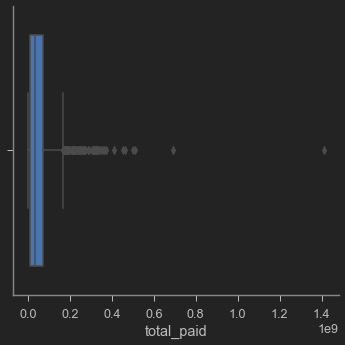

In [7]:
sns.catplot(x='total_paid', data=datamart, kind='box')
plt.show()

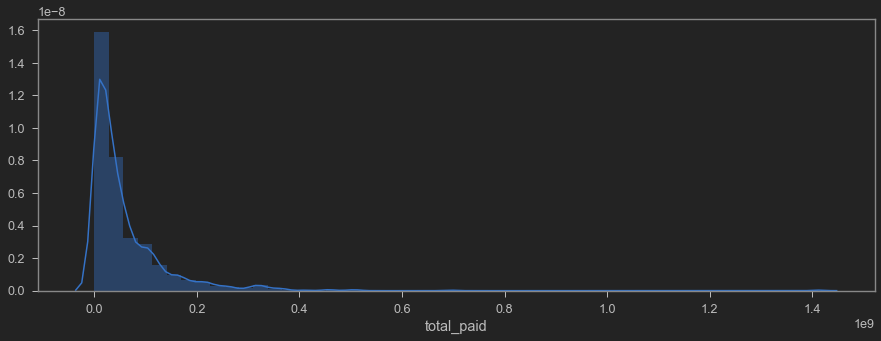

In [8]:
plt.figure(figsize=(15,5))
sns.distplot(datamart.total_paid,kde=True,bins=50)
plt.show()

In [9]:
datamart.arrears_days.describe()

count    1101.000000
mean       13.736603
std        35.195398
min         0.000000
25%         0.000000
50%         2.000000
75%        11.000000
max       347.000000
Name: arrears_days, dtype: float64

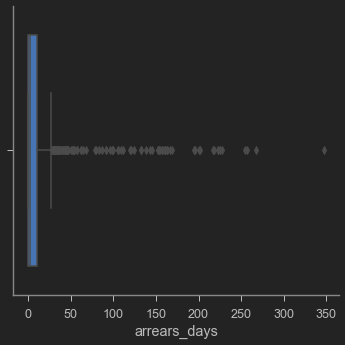

In [10]:
sns.catplot(x='arrears_days', data=datamart, kind='box')
plt.show()

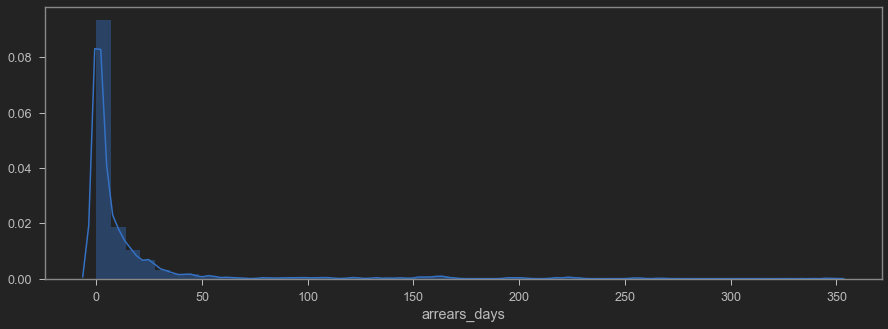

In [11]:
plt.figure(figsize=(15,5))
sns.distplot(datamart.arrears_days,kde=True,bins=50)
plt.show()

### Construyendo segmento RFM

+ Para la antiguedad(recency) se le asigna el mayor percentil al cliente que ha usado recientemente los servicios. Menor valor al que lleva tiempo sin usarlos.
+ Para el caso de la frecuencia(medida por los dias de retraso) y el valor monetario. Entre mayor sea el valor estas variables asi mismo se le asignara los percentiles

In [12]:
datamart.describe()

,client_id,loan_id,recency,arrears_days,total_paid
count,1101.000000,1101.000000,1072.000000,1101.000000,1.101000e+03
mean,3834.189827,1289.960036,285.156716,13.736603,5.987304e+07
std,3207.175568,522.897687,175.700752,35.195398,8.466162e+07
min,14.000000,5.000000,23.000000,0.000000,0.000000e+00
25%,1523.000000,1000.000000,191.000000,0.000000,1.165102e+07
50%,2479.000000,1357.000000,206.000000,2.000000,3.260240e+07
75%,5070.000000,1701.000000,311.000000,11.000000,7.375648e+07
max,13949.000000,2083.000000,1207.000000,347.000000,1.411365e+09


In [13]:
# Create numbered labels
r_labels = range(4,0,-1)

#Crear nuevo dataframe con los percentiles
recency_quartiles = pd.qcut(datamart['recency'], q=4, labels=r_labels)
datamart = datamart.assign(R = recency_quartiles.values)
datamart['R'].fillna(4, inplace=True)
datamart

,client_id,loan_id,recency,arrears_days,total_paid,R
0,14,14,965.0,0.0,33580092.0,1
1,98,1651,218.0,7.0,9700064.0,2
2,141,200,257.0,0.0,68591665.0,2
3,141,204,433.0,0.0,47863133.0,1
4,141,1241,253.0,0.0,67041762.0,2
...,...,...,...,...,...,...
1096,13773,2045,NaN,21.0,0.0,4
1097,13893,2067,181.0,4.0,9225206.0,4
1098,13912,2065,185.0,0.0,5990892.0,4
1099,13937,2071,184.0,1.0,9984820.0,4


##### Total pagado

In [14]:
#f_quartiles = pd.qcut(datamart.arrears_days, q=4, labels=range(1,5))
t_quartiles = pd.qcut(datamart.total_paid, q=4, labels=range(1,5), precision=0)

# Agregar una nueva columna y asignar los valores
datamart = datamart.assign(T = t_quartiles.values)
datamart

,client_id,loan_id,recency,arrears_days,total_paid,R,T
0,14,14,965.0,0.0,33580092.0,1,3
1,98,1651,218.0,7.0,9700064.0,2,1
2,141,200,257.0,0.0,68591665.0,2,3
3,141,204,433.0,0.0,47863133.0,1,3
4,141,1241,253.0,0.0,67041762.0,2,3
...,...,...,...,...,...,...,...
1096,13773,2045,NaN,21.0,0.0,4,1
1097,13893,2067,181.0,4.0,9225206.0,4,1
1098,13912,2065,185.0,0.0,5990892.0,4,1
1099,13937,2071,184.0,1.0,9984820.0,4,1


##### Construcción de segmento RFM y RFM score
+ Concatenar los valores de los cuartiles
+ Sumar los valores de los cuartiles

In [15]:
def join_rm(x): return str(x['R']) + str(x['T'])

datamart['RFM_Segment'] = datamart.apply(join_rm, axis=1)
datamart['RFM_Score'] = datamart[['R','T']].sum(axis=1)

In [16]:
datamart

,client_id,loan_id,recency,arrears_days,total_paid,R,T,RFM_Segment,RFM_Score
0,14,14,965.0,0.0,33580092.0,1,3,13,4.0
1,98,1651,218.0,7.0,9700064.0,2,1,21,3.0
2,141,200,257.0,0.0,68591665.0,2,3,23,5.0
3,141,204,433.0,0.0,47863133.0,1,3,13,4.0
4,141,1241,253.0,0.0,67041762.0,2,3,23,5.0
...,...,...,...,...,...,...,...,...,...
1096,13773,2045,NaN,21.0,0.0,4,1,41,5.0
1097,13893,2067,181.0,4.0,9225206.0,4,1,41,5.0
1098,13912,2065,185.0,0.0,5990892.0,4,1,41,5.0
1099,13937,2071,184.0,1.0,9984820.0,4,1,41,5.0


### Clusterización preeliminar aplicando percentiles de metricas RFM

In [17]:
def segment_me(df):
    if df['RFM_Score'] >= 7:
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6):
        return 'Silver'
    else:
        return 'Bronze'

datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart.groupby('General_Segment').agg({
    'recency': 'mean',
    'total_paid': ['mean', 'count']}).round(1)

recency   total_paid      
                   mean         mean count
General_Segment                           
Bronze            297.2   41648079.4   549
Gold              181.9  101635104.1   168
Silver            315.3   67658126.8   384

#### Centrando varibles con diferentes 'means'

In [18]:
# Copiar dataframe
datamart_rt = datamart

In [19]:
# Dejar solo las columnas que se necesitan
datamart_rt.drop(['R', 'T', 'RFM_Segment', 'General_Segment'], axis=1, inplace=True)

In [20]:
datamart_centered = datamart_rt - datamart_rt.mean()
datamart_centered.describe().round(2)

,client_id,loan_id,recency,arrears_days,total_paid,RFM_Score
count,1101.00,1101.00,1072.00,1101.00,1.101000e+03,1101.00
mean,0.00,0.00,0.00,0.00,-0.000000e+00,-0.00
std,3207.18,522.90,175.70,35.20,8.466162e+07,1.31
min,-3820.19,-1284.96,-262.16,-13.74,-5.987304e+07,-3.07
25%,-2311.19,-289.96,-94.16,-13.74,-4.822202e+07,-1.07
50%,-1355.19,67.04,-79.16,-11.74,-2.727064e+07,-0.07
75%,1235.81,411.04,25.84,-2.74,1.388344e+07,0.93
max,10114.81,793.04,921.84,333.26,1.351492e+09,2.93


In [21]:
#datamart_rt.set_index('client_id', inplace=True)

In [22]:
#datamart_rt

Como se puede observar las desviaciones estandar no se encuentran en un mismo rango. Por lo que se hace necesario re escalar los datos. Se utilizará StandardScaler

### Rescalamiento de los datos 

In [23]:
def reescalamiento(df):
    """Esta función reescala los datos financieros"""
    # Set index
    df.set_index('client_id', inplace=True)

    # Reescalar los datos
    scaler = StandardScaler()
    scaler.fit(df)
    datamart_normalized = scaler.transform(datamart_rt)

    # Create a pandas DataFrame
    data_normalized_pandas = pd.DataFrame(
        datamart_normalized, index=df.index, columns=df.columns)

    data_normalized_pandas.reset_index('client_id', inplace=True)

    return data_normalized_pandas

In [24]:
normalizada = reescalamiento(datamart_rt)

In [25]:
normalizada.shape

(1101, 6)

#### AQUI SE HACE EL MERGE CON LA OTRA DATA

* Merge a los dataframe --> 'data_normalized_pandas' y los datos que hay en matriz cliente

### OneHotEncoding

In [26]:
columnas_OHE = ['state', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación',
                      'Procesos judiciales', 'Alertas', 'Website empresa', 'Instagram empresa',
                       'LinkedIn empresa', 'LinkedIn empresarios',  'Impacto', 'Acceso previso a la banca',
                      'Mujeres empresarias']

In [27]:
# OneHotEncoding para variables categoricas
column_trans = make_column_transformer(
    (OneHotEncoder(), columnas_OHE),
    remainder='passthrough')

In [28]:
print(column_trans.fit_transform(clean).tolist()[1])

NameError: name 'clean' is not defined

In [ ]:
clean.shape

In [ ]:
# Imprimir cada columna del dataset clasificada por onehotencoder y los que no pasaron por el proceso de transformación
column_trans.get_feature_names()

#### Significado de OneHotEncoding
* state 

1 0 0--> Late

0 1 0--> PAID. 

0 0 1--> PARTIALLY_PAID

* Recursos 


1 0 0 0 --> CR

0 1 0 0 --> KT - CO

0 0 1 0--> KT - EX

0 0 0 1 --> SP

* Plazo

1 0 0 0 --> 13 a 24 meses

0 1 0 0 --> 25 a 36 meses

0 0 1 0--> Menos de 12 meses

0 0 0 1 --> Más de 37 meses